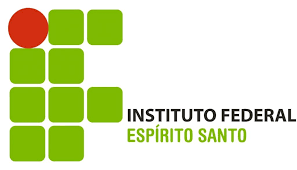

# MRS: Wikipedia

> Alunos: Davi, Nelson, Raido

## 1. Introdução

A Wikipédia integra um dos vários projetos mantidos pela Wikimedia, com mais de 43 milhões de artigos (1.009.664 em português, até 6 de julho de 2019) escritos de forma conjunta e voluntária por várias pessoas ao redor do mundo. Em outubro de 2013, havia edições ativas da Wikipédia em 277 idiomas; lançada em 15 de janeiro de 2001, tornou-se a maior e mais popular obra de referência geral na Internet, sendo classificada em novembro de 2018 na quinta posição entre todos os websites do Alexa. Em 2010, tinha cerca de 365 milhões de leitores. A Wikipédia é uma ferramenta de pesquisa amplamente utilizada por estudantes e tem influenciado o trabalho de pesquisadores, acadêmicos e demais leitores.

### 1.1 Composição da rede

Um estudo de 2008 conduzido por pesquisadores da Universidade Carnegie Mellon e do Palo Alto Research Center apresentou uma distribuição de temas, bem como o crescimento (de julho de 2006 a janeiro de 2008) em cada campo relativos à Wikipédia em inglês:

* Cultura e artes: 30% (210%)
* Biografias e pessoas: 15% (97%)
* Geografia e locais: 14% (52%)
* Sociedade e ciências sociais: 12% (83%)
* História e eventos: 11% (143%)
* Ciências naturais e físicas: 9% (213%)
* Tecnologia e ciência aplicada: 4% (-6%)
* Religiões e sistemas de crenças: 2% (38%)
* Saúde: 2% (42%)
* Matemática e lógica: 1% (146%)
* Pensamento e filosofia: 1% (160%)

## 2. Teoria

As páginas de artigos da Wikipedia são conectadas por meio de hyperlinks (grafo direcionado), criando-se componentes conectados a partir de temáticas, referências, locais, geografia, idioma, cultura, entre outros aspectos. Este conteúdo é disponibilizado pela [API do MediaWiki](https://www.mediawiki.org/wiki/API), que permite um certo grau de interação com a plataforma da Wikipedia: extraindo sumário, conteúdo, relações de páginas, entre outros. Para obtermos este conteúdo neste notebook, utilizaremos dessa API por meio do pacote [wikipedia (PyPI)]( https://pypi.org/project/wikipedia/), e realizaremos algumas operações a fim de realizar uma análise descritivo-exploratória de sua rede.

## 3. Funcionamento

Para configurar o acesso à Wikipédia por meio da MediaWiki API, basta importar o módulo ```wikipedia```. [Alguns exemplos](https://wikipedia.readthedocs.io/en/latest/quickstart.html) de suas funções abaixo:

```
>>> ny = wikipedia.page("New York")

>>> ny.title
u'New York'

>>> ny.url
u'http://en.wikipedia.org/wiki/NewYork'

>>> ny.content
u'New York is a state in the Northeastern region of the United States. New York is the 27th-most exten'...

>>> ny.images[0]
u'http://upload.wikimedia.org/wikipedia/commons/9/91/New_York_quarter%2C_reverse_side%2C_2001.jpg'

>>> ny.links[0]
u'1790 United States Census'
```

## 4. Prática

No exemplo abaixo, iremos realizar as seguintes operações:

* Instalar dependências
* Importar bibliotecas
* Definir funções e variáveis
* Variáveis de definição do usuário
* Pesquisar pelo título de artigos na Wikipedia
* Conteúdo de uma página da Wikipedia
* Sumário de uma página específica da Wikipedia
* Construir uma rede de conexões entre páginas da Wikipedia
* Calcular suas medidas de centralidade de rede e modularidade
  * *Estatísticas por artigo (nó ou vértice)*
  * *Estatísticas considerando a rede inteira*
  * *Histograma de grau da rede*
* Plotar um grafo da rede após aplicar filtro k-core
  * *Grafo da rede filtrada atribuindo cores aos módulos*
  * *Outros algoritmos de distribuição para espacializar os nós da rede filtrada*
* Histograma de grau e subgrafo dos módulos identificados
* Determinar artigos de maior centralidade de grau por módulo
* Calcular os maiores módulos a partir da soma de suas centralidades
  * *Estatísticas gerais dos módulos*
* Normalizar os valores de centralidade dos módulos
* Scatter plot dos módulos a partir de suas centralidades normalizadas

### Instalar dependências

In [0]:
!pip install community wikipedia

### Importar bibliotecas

In [0]:
import collections
import community
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import wikipedia as wp

from sklearn.preprocessing import MinMaxScaler

### Definir funções e variáveis

In [0]:
def wiki_summary(query, sentences=10, lang='en'):
    wp.set_lang(lang)
    return wp.summary(query, sentences=sentences)

def wiki_page(query, lang='en'):
    wp.set_lang(lang)
    return wp.page(query)

def wiki_search(query, lang='en'):
    wp.set_lang(lang)
    return wp.search(query)

def wiki_graph(query, lang='en', levels=1, n=None):
    success = 0
    errors  = 0
    depth   = 0
    G = nx.Graph()
    if isinstance(query,str):
        query = [query]
    while True:
        depth += 1
        for q in query:
            try:
                w = wp.page(q, lang)
                links = w.links[:n]
                for i in links:
                    G.add_node(i)
                    G.add_edge(i,q)
            except Exception as e:
                errors += 1
                # print(str(e)) # raise
                break
            else:
              query = links
              success += 1
        if levels == depth:
            break
    print('Success:', success, '\nErrors:', errors)
    return G

def graph_histogram(G, title="Histograma de grau"):
    deg = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = collections.Counter(deg)
    deg, cnt = zip(*degree_count.items())
    fig, ax = plt.subplots(figsize=(10,6))
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title(title)
    plt.ylabel("Nós")
    plt.xlabel("Grau")
    ax.set_xticks([d for d in deg])
    ax.set_xticklabels(d for d in deg)
    plt.plot()

def nx_centrality(G, it=100, deg=True, clu=True, clo=True, eig=True,
    bet=True, bro=True, bri=True, mod=True, normalized=False):
    '''
    Returns a data frame containing network statistics for
    the nodes and their communities from a NetworkX.Graph():
    '''
    def normalize(D):
        max_d = max(D.values())
        for key in D:
            D[key] /= max_d

    def add_m(m,c):
        measures.append(m)
        columns.append(c)

    columns, measures = [], []

    if deg:
        #degree      = nx.degree_centrality(G)
        degree      = dict(nx.degree(G))
        add_m(degree, 'degree')

    if clu:
        clustering  = nx.clustering(G)
        add_m(clustering, 'clustering')

    if clo:
        closeness   = nx.closeness_centrality(G)
        add_m(closeness, 'closeness')

    if eig:
        eigenvector = nx.eigenvector_centrality(G, it)
        add_m(eigenvector, 'eigenvector')

    if bet:
        betweenness = nx.betweenness_centrality(G, normalized=normalized)
        add_m(betweenness, 'betweenness')

    if bro:
        brokering   = nx_brokering_centrality(G, normalized=normalized)
        add_m(brokering, 'brokering')

    if bri:
        bridgeness  = nx_bridgeness_centrality(G, betweenness if bet else None,
                                               normalized=normalized)
        add_m(bridgeness, 'bridgeness')

    if normalized == True:
        normalize(degree) if deg else None
        normalize(clustering) if clu else None
        normalize(closeness) if clo else None
        normalize(eigenvector) if eig else None
        normalize(betweenness) if bet else None
        normalize(brokering) if bro else None
        normalize(bridgeness) if bri else None
    
    df = pd.DataFrame()
    for i in range(0,len(measures)):
        c = columns[i]
        for x in measures[i]:
            measure = measures[i][x]
            df.loc[x, c] = measure

    if mod:
        if G.is_directed():
            G = G.to_undirected()
        partition = community.best_partition(G)
        modularity = community.modularity(partition, G)
        df['partition'] = pd.Series(partition)
        print('Modules:', len(df['partition'].unique()),
              '\nModularity:', modularity)
    
    return df

def nx_bridgeness_centrality(G, betweenness=None, normalized=True):
    '''
    Computes Bridgeness Centrality for a graph G.

    For each node the bridgeness coefficient is defined as:
        bridge_coeff[node] =  (1/degree[node]) / sum(1/degree[neighbors[node]])

    The bridgeness centrality of a node is defined as:
        bridgeness[node] = betweenness(node) * bridge_coeff[node]

    Since computing of betweennes can take a lot of time,
    it's possible to provide the betweenness as a parameter.

    Note that only nodes with degree >= 1 will be returned.
    '''
    if betweenness is None:
        betweenness = nx.betweenness_centrality(G)

    bridgeness = {}
    for node in G.nodes():
        degree_node = nx.degree(G,node)
        if degree_node > 0:
            neighbors_degree  = dict(nx.degree(G, nx.neighbors(G, node))).values()
            sum_neigh_inv_deg = sum((1.0/d) for d in neighbors_degree)
            if sum_neigh_inv_deg > 0:
                bridge_coeff = (1.0/degree_node) / sum_neigh_inv_deg
                bridgeness[node] = betweenness[node] * bridge_coeff
            else: bridgeness[node] = 0

    if normalized == True:
        max_d = max(bridgeness.values())
        for key in bridgeness:
            bridgeness[key] /= max_d

    return bridgeness

def nx_brokering_centrality(G, normalized=True):
    '''
    Computes Brokering Centrality for a graph G.

    For each node brokering centrality is defined as:
        brokering[node] =  (1 - clustering[node]) * degree[node]
    '''
    degree     = nx.degree_centrality(G)
    clustering = nx.clustering(G)

    brokering  = {}
    for node in G.nodes():
        brokering[node] =  (1 - clustering[node]) * degree[node]

    if normalized == True:
        max_d = max(brokering.values())
        for key in brokering:
            brokering[key] /= max_d

    return brokering

def nx_plot(G, figsize=(10, 10), labels=True, layout='kamada_kawai_layout'):
    '''
    Plots a NetworkX.Graph() object with slightly better default parameters.
    '''
    ndTypes = []
    ndColors = []
    colors = "rbcmykg"

    fig = plt.figure(1, figsize=figsize, dpi=80, facecolor='w', edgecolor='g')
    ax = fig.add_subplot(1,1,1)
    #fig.set_facecolor('w')

    if layout == 'spring_layout':
        k = 4 / math.sqrt(len(G.nodes()))
        pos = nx.spring_layout(G, k=k)

    elif layout == 'circular_layout':
        pos = nx.circular_layout(G)
    elif layout == 'kamada_kawai_layout':
        pos = nx.kamada_kawai_layout(G)
    elif layout == 'fruchterman_reingold_layout':
        pos = nx.fruchterman_reingold_layout(G)
    elif layout == 'spectral_layout':
        pos = nx.spectral_layout(G)

    for nd in G.nodes(data=True):
        if 'partition' in nd[1]:
            if nd[1]['partition'] not in ndTypes:
                ndTypes.append(nd[1]['partition'])
            ndColors.append(colors[ndTypes.index(nd[1]['partition']) % len(colors)])
        elif len(ndColors) > 1:
            raise RuntimeError("Some nodes do not have a partition")

    if len(ndColors) < 1:
        node_color = colors[0]
    else: node_color = ndColors

    nx.draw_networkx_nodes(G, pos=pos, node_color=node_color, node_shape='8', node_size=100, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, width=0.2, ax=ax)
    nx.draw_networkx_labels(G, pos=pos, font_size=10, ax=ax) if labels else None

    plt.axis('off')
    plt.show()

#### Variáveis de definição do usuário

In [0]:
page = "Data science" # <-- título de uma página na Wikipedia
lang = "en"           # <-- código de idioma ("en"; "es"; "pt")

### Pesquisar pelo título de artigos na Wikipedia

In [0]:
w = wiki_search(page, lang=lang); w

['Data science',
 'Master in Data Science',
 'Data',
 'Open science data',
 'Data structure',
 'Data analysis',
 'Computer science',
 'Big data',
 'IBM Data Science Experience',
 'Committee on Data for Science and Technology']

### Conteúdo de uma página da Wikipedia

In [0]:
w = wiki_page(page, lang=lang)
print(w.title, '\n', w.url, '\n\nConteúdo:',  w.content)

Data science 
 https://en.wikipedia.org/wiki/Data_science 

Conteúdo: Data science is a multi-disciplinary field that uses scientific methods, processes, algorithms and systems to extract knowledge and insights from structured and unstructured data. Data science is the same concept as data mining and big data: "use the most powerful hardware, the most powerful programming systems, and the most efficient algorithms to solve problems".Data science is a "concept to unify statistics, data analysis, machine learning and their related methods" in order to "understand and analyze actual phenomena" with data. It employs techniques and theories drawn from many fields within the context of mathematics, statistics, computer science, and information science. Turing award winner Jim Gray imagined data science as a "fourth paradigm" of science (empirical, theoretical, computational and now data-driven) and asserted that "everything about science is changing because of the impact of information techn

### Sumário de uma página específica da Wikipedia

In [0]:
sentences = 9 # <-- número máximo de frases
w = wiki_summary(page, sentences=sentences, lang=lang); w

'Data science is a multi-disciplinary field that uses scientific methods, processes, algorithms and systems to extract knowledge and insights from structured and unstructured data. Data science is the same concept as data mining and big data: "use the most powerful hardware, the most powerful programming systems, and the most efficient algorithms to solve problems".Data science is a "concept to unify statistics, data analysis, machine learning and their related methods" in order to "understand and analyze actual phenomena" with data. It employs techniques and theories drawn from many fields within the context of mathematics, statistics, computer science, and information science. Turing award winner Jim Gray imagined data science as a "fourth paradigm" of science (empirical, theoretical, computational and now data-driven) and asserted that "everything about science is changing because of the impact of information technology" and the data deluge. In 2015, the American Statistical Associa

### Construir uma rede de conexões entre páginas da Wikipedia

In [0]:
pages  = ["Data science"] # <-- aceita uma string ou um array
lang   = "en"             # <-- código de idioma, exemplos: "en"; "pt"; "es"
levels = 3                # <-- níveis de conexão para pesquisar hyperlinks
n      = 50               # <-- número máximo de conexões por página

In [0]:
G = wiki_graph(pages, lang=lang, levels=levels, n=n)

Success: 92 
Errors: 0


### Calcular suas medidas de centralidade de rede e modularidade

In [0]:
df = nx_centrality(G, normalized=False) # <-- normalização feita a posteriori

Modules: 26 
Modularity: 0.7498850980628553


####  Estatísticas por artigo (nó ou vértice)

In [0]:
measure = 'eigenvector' # <-- ordenar por centralidade de autovetor
df.sort_values(by=measure, ascending=False).head(10) # <-- máximo de linhas

,degree,clustering,closeness,eigenvector,betweenness,brokering,bridgeness,partition
CURE data clustering algorithm,52.0,0.342857,0.331416,0.198909,51089.680611,0.013795,121.458163,1
Association rule learning,51.0,0.349020,0.339781,0.197625,33795.215388,0.013403,54.838171,1
DeepDream,51.0,0.346667,0.337926,0.196581,32126.452124,0.013452,54.831579,1
Autoencoder,51.0,0.345882,0.339455,0.196244,32459.943477,0.013468,54.757688,1
Automated machine learning,51.0,0.342745,0.333468,0.195645,28263.940726,0.013532,51.237307,1
Conditional random field,51.0,0.338824,0.336640,0.194343,31880.137746,0.013613,50.997121,1
Bootstrap aggregating,51.0,0.336471,0.332171,0.194250,25632.391722,0.013662,50.088355,1
Anomaly detection,51.0,0.334118,0.331327,0.193311,29603.580152,0.013710,49.374120,1
DBSCAN,51.0,0.334118,0.331327,0.193292,27227.003043,0.013710,49.061918,1
Bias–variance dilemma,52.0,0.322449,0.330091,0.192567,33982.113475,0.014224,48.518357,1


#### Estatísticas considerando a rede inteira

In [0]:
df.describe()

,degree,clustering,closeness,eigenvector,betweenness,brokering,bridgeness,partition
count,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000
mean,3.405165,0.061175,0.247473,0.004683,3792.468523,0.001223,739.253370,9.947538
std,9.775874,0.216397,0.019592,0.019539,30138.256013,0.003635,3372.579262,7.293467
min,1.000000,0.000000,0.227540,0.000029,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.235995,0.000215,0.000000,0.000404,0.000000,3.000000
50%,1.000000,0.000000,0.243392,0.000510,0.000000,0.000404,0.000000,9.000000
75%,1.000000,0.000000,0.250937,0.001840,0.000000,0.000404,0.000000,15.000000
max,81.000000,1.000000,0.414422,0.198909,902671.339657,0.031157,68312.670825,25.000000


#### Histograma de grau da rede

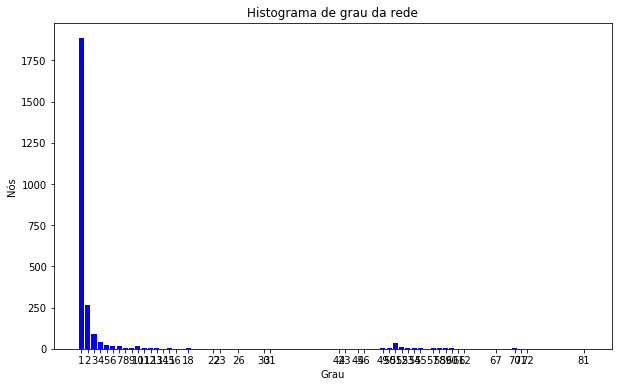

In [0]:
graph_histogram(G, 'Histograma de grau da rede')

### Plotar um grafo da rede após aplicar filtro k-core

In [0]:
k = 7 # <-- definir coreness para aplicar k-core
      #     no nosso exemplo, k=7 para top 100 nós

# adicionar atributo partição dos nós (cores)
nx.set_node_attributes(G, df['partition'], 'partition')

# filtrar
K = G
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K, k=k)

print('Graph:', len(G.nodes()), 'nodes,', len(G.edges()), 'edges',
      '\nk='+str(k),': ', len(K.nodes()), 'nodes,', len(K.edges()), 'edges')

Graph: 2478 nodes, 4214 edges 
k=7 :  96 nodes, 874 edges


#### Grafo da rede filtrada atribuindo cores aos módulos

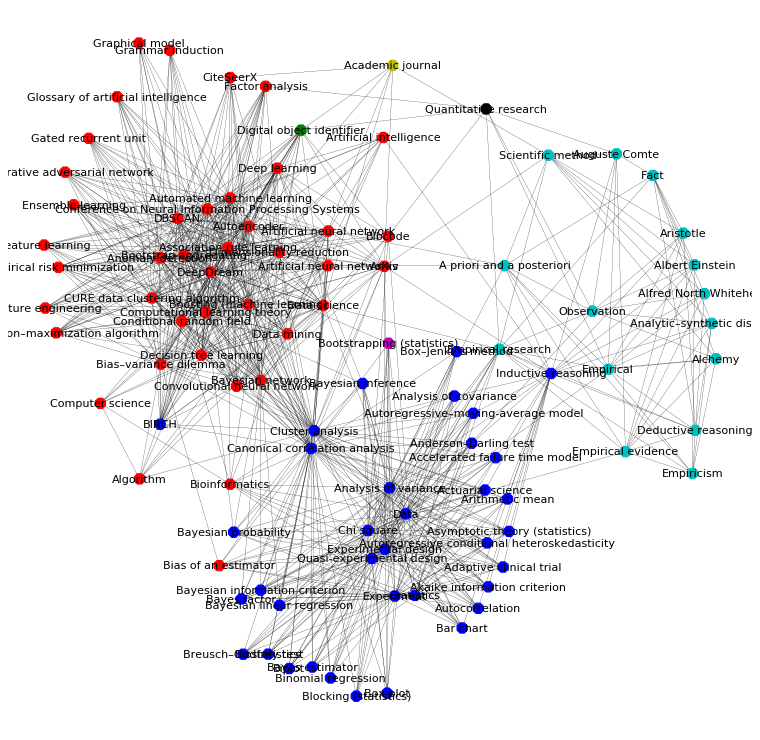

In [0]:
# plotar a rede filtrada
nx_plot(K, (12,12), layout='kamada_kawai_layout', labels=True)

#### Outros algoritmos de distribuição para espacializar os nós da rede filtrada

=> circular_layout


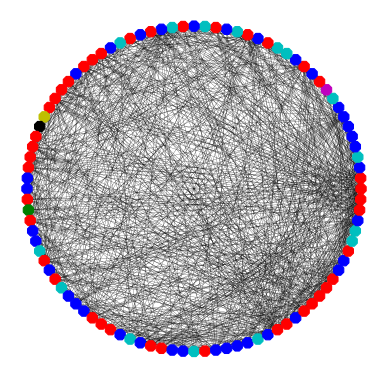

=> spring_layout


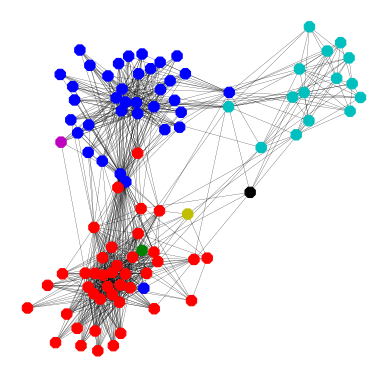

=> fruchterman_reingold_layout


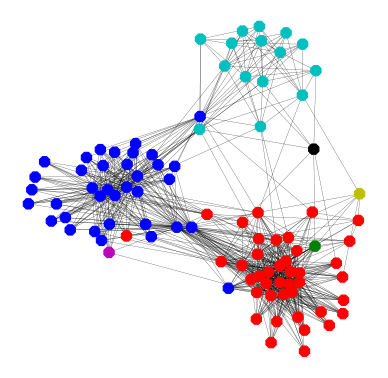

In [0]:
for layout in ['circular_layout', 'spring_layout', 'fruchterman_reingold_layout']:
    print('=>', layout)
    nx_plot(K, (6, 6), False, layout)

### Histograma de grau e subgrafo dos módulos identificados

In [0]:
for p in sorted(df.partition.unique()):
    title = 'Module '+str(p)
    nodes = df[df['partition'] == p].index
    M = nx.subgraph(G, nodes)
    graph_histogram(M, title=title)
    nx_plot(M, (4,4), labels=False) # <-- títulos

### Determinar artigos de maior centralidade de grau por módulo

In [0]:
measure = 'degree' # <-- medida de centralidade para considerar
top     = 10       # <-- número máximo de nós para retornar

In [0]:
for p in sorted(df.partition.unique()):
    print('=> Module', p)
    print(df[df['partition'] == p].sort_values(by=measure, ascending=False)[measure].head(top), '\n')

=> Module 0
Academic journal          58.0
Academic publishing       54.0
Academy                   52.0
Academic discipline        7.0
Academic writing           3.0
Book                       3.0
Article-level metrics      2.0
Author                     2.0
Collection of articles     2.0
Citation index             2.0
Name: degree, dtype: float64 

=> Module 1
Artificial neural networks        72.0
Artificial neural network         70.0
Bayesian network                  70.0
Deep learning                     59.0
Convolutional neural network      57.0
CURE data clustering algorithm    52.0
Bias–variance dilemma             52.0
Conditional random field          51.0
Dimensionality reduction          51.0
DeepDream                         51.0
Name: degree, dtype: float64 

=> Module 2
David Donoho                          51.0
C.F. Jeff Wu                          43.0
Integrated Authority File             31.0
American Statistical Association      30.0
Adriaan de Groot              

### Calcular os maiores módulos a partir da soma de suas centralidades

In [0]:
measures = ['degree', 'clustering', 'closeness', 'eigenvector',
            'betweenness', 'brokering', 'bridgeness']

df_modules = pd.DataFrame()
for p in sorted(df.partition.unique()):
    partition = df[df['partition'] == p]
    M = nx.subgraph(G, partition.index)
    df_modules.loc[p, 'order'] = M.order() # <-- nodes
    df_modules.loc[p, 'size'] = M.size() # <-- edges
    df_modules.loc[p, 'diameter'] = nx.diameter(M)
    df_modules.loc[p, 'density'] = nx.density(M)
    for c in measures:
        df_modules.loc[p, c] = partition[c].sum()

#### Estatísticas gerais dos módulos

In [0]:
df_modules.describe()

,order,size,diameter,density,degree,clustering,closeness,eigenvector,betweenness,brokering,bridgeness
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,2.600000e+01,26.000000,26.000000
mean,95.307692,136.884615,3.192308,0.032381,324.538462,5.830420,23.586038,0.446372,3.614514e+05,0.116526,70456.532713
std,71.960972,169.684726,1.166850,0.012457,400.794534,16.597746,18.431374,1.477794,4.766933e+05,0.123085,82303.585941
min,38.000000,37.000000,2.000000,0.013116,90.000000,0.000000,9.550207,0.002218,1.036576e+05,0.035897,34.186670
25%,47.250000,46.250000,2.000000,0.022150,97.500000,0.002547,11.201328,0.031347,1.157374e+05,0.039350,14707.186655
50%,75.500000,78.500000,3.500000,0.031769,192.500000,0.340677,18.656649,0.051156,2.106310e+05,0.074973,51049.984815
75%,112.500000,144.250000,4.000000,0.042332,336.000000,4.860621,27.787686,0.167048,3.649312e+05,0.130483,82756.514561
max,335.000000,775.000000,6.000000,0.052632,1804.000000,84.820209,86.798149,7.552698,2.079696e+06,0.474891,330648.498089


### Normalizar os valores de centralidade dos módulos

In [0]:
measures = ['degree', 'clustering', 'closeness', 'eigenvector',
            'betweenness', 'brokering', 'bridgeness']

df_ = pd.DataFrame(MinMaxScaler().fit_transform(df_modules),
                   columns=df_modules.columns, index=df_modules.index)

df_.sort_values('degree', ascending=False).head(10) # <-- top 10

,order,size,diameter,density,degree,clustering,closeness,eigenvector,betweenness,brokering,bridgeness
1,1.000000,1.000000,0.50,0.018652,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.745111
14,0.808081,0.634146,0.50,0.000000,0.631855,0.093357,0.759551,0.024147,0.822412,0.968379,1.000000
9,0.363636,0.472900,0.50,0.590925,0.514586,0.161726,0.368770,0.183743,0.216188,0.697440,0.179214
10,0.218855,0.176152,0.50,0.472609,0.209452,0.069214,0.212457,0.080690,0.135489,0.305087,0.444997
18,0.269360,0.178862,0.50,0.287639,0.187281,0.062318,0.242707,0.006575,0.122417,0.276707,0.518746
5,0.353535,0.154472,0.50,0.044453,0.163944,0.039588,0.341454,0.015424,0.167748,0.250336,0.481544
2,0.360269,0.163957,1.00,0.051074,0.151692,0.042267,0.325199,0.013806,0.141550,0.228221,0.219877
0,0.235690,0.117886,0.50,0.211178,0.119020,0.155530,0.220343,0.017838,0.114516,0.160326,0.259117
7,0.222222,0.104336,0.50,0.206720,0.112602,0.002449,0.205494,0.022448,0.098459,0.177184,0.356227
3,0.255892,0.113821,0.25,0.143488,0.109685,0.083004,0.241339,0.019978,0.100187,0.159090,0.122894


### Scatter plot dos módulos a partir de suas centralidades normalizadas

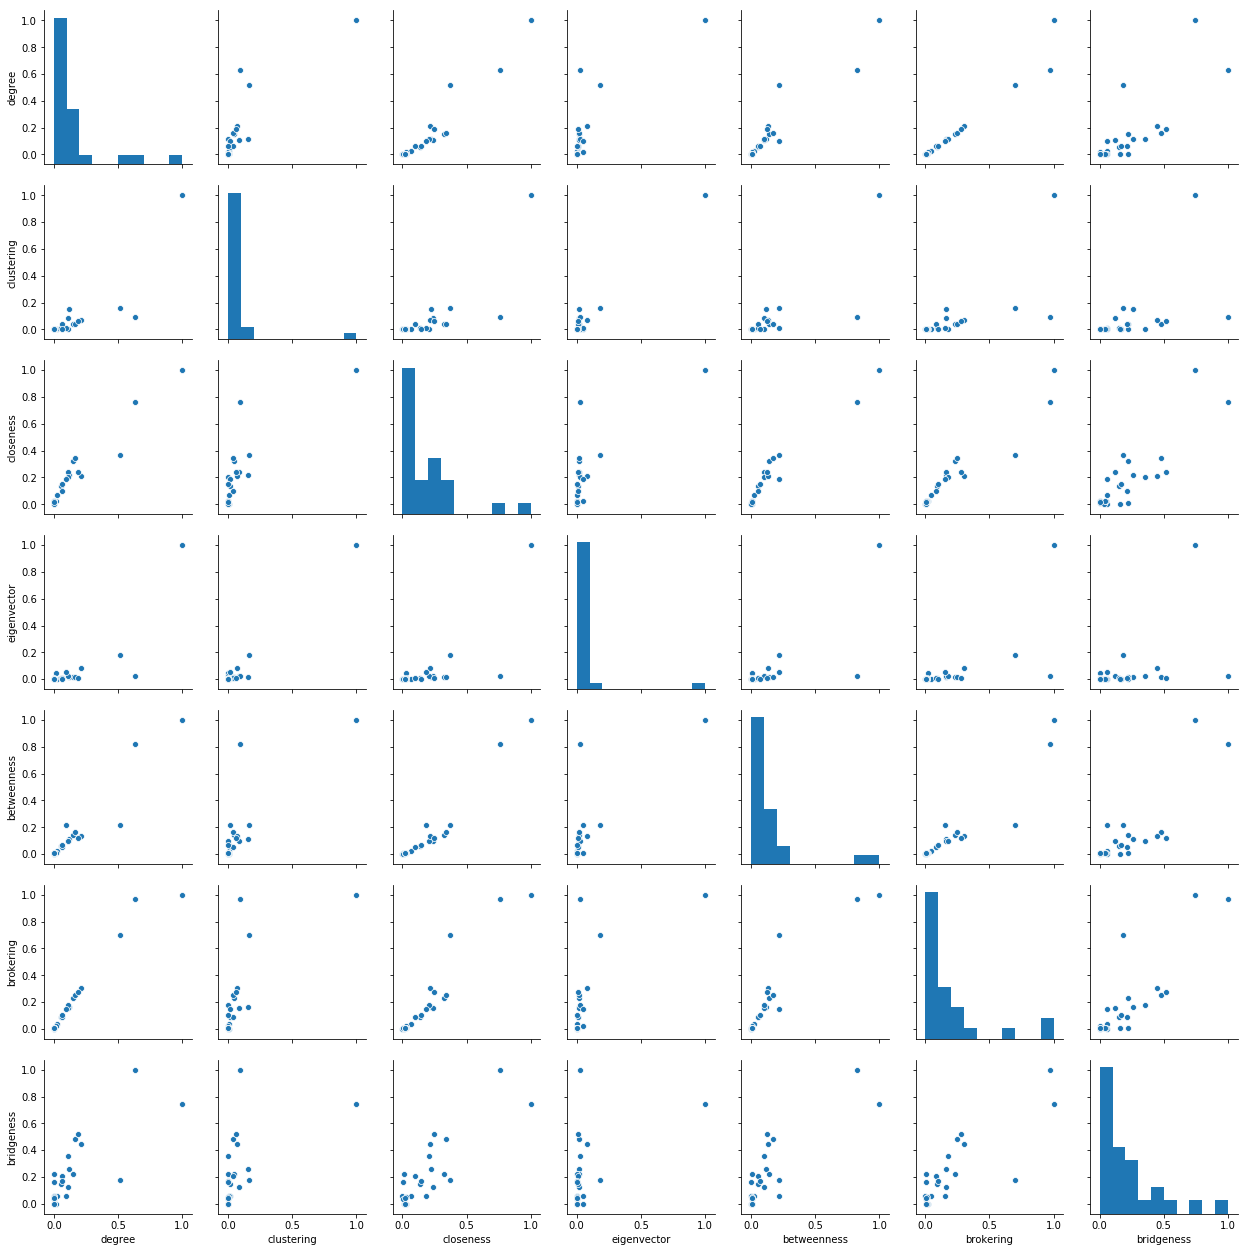

In [0]:
sns.pairplot(df_[measures])

### Breve análise da rede coletada da Wikipédia

No exemplo trabalhado, selecionamos uma página de artigo da Wikipédia -- "**[Data Science](https://en.wikipedia.org/wiki/Data_science)**" em inglês -- objetivando encontrar as suas conexões com outros mais artigos e verbetes na plataforma. A partir dos métodos expostos, fomos capazes de extrair os hyperlinks que conectam este tópico a outros mais relacionados ao artigo original. De posse destes dados, procuramos **1)** calcular as medidas de centralidade de cada nó/vertice/página, incluindo-se algumas não presentes por padrão na biblioteca ```networkx``` (*brokering* e *bridgeness*); **2)** identificar seus módulos a partir do algoritmo de modularidade disponível pela biblioteca ```community```; e **3)** distribuir a rede e espacializá-la visualmente. Baseando-se nestes resultados, calculamos também **4)** as estatísticas gerais por módulo e centralidades médias para o conjunto de módulos e **5)** suas correlações a partir das medidas de centralidade calculadas.

Dessa forma, identificamos que, por exemplo, o artigo **[Empirical Research](https://en.wikipedia.org/wiki/Empirical_research)** tem a maior centralidade de intermediação para com todos os vértices retornados, assumindo-se como de menor distância no caminho conectando-o a outros artigos. Já ordenando-os por seus valores de centralidade de autovetor, os artigos de maior relevância que encontramos conectando-os a outros nós de destaque foram **[CURE data clustering algorithm](https://en.wikipedia.org/wiki/CURE_algorithm)**, um algoritmo para grandes bases de dados e uma alternativa robusta ao k-means; **[Association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning)**, um método de *machine learning* para descobrir relações entre variáveis; e **[DeepDream](https://en.wikipedia.org/wiki/DeepDream)**,um  programa de computação visual (CV) que utiliza redes neuras convolucionais para encontrar padrões em imagens por pareidolia, cujo efeito visual acarretou seu nome.

Das comunidades identificadas pelo algoritmo de modularidade, notam-se que os **módulos 1, 14 e 9** são os de maior centralidade de grau da rede (referentes aos nós principais **[Artificial Neural Networks](https://en.wikipedia.org/wiki/Artificial_neural_networks)**; **[Deductive reasoning](https://en.wikipedia.org/wiki/Deductive_reasoning)** e **[Phenomenon](https://en.wikipedia.org/wiki/Phenomenon)**, respectivamente), indicando-se uma maior quantidade de conexões para esses tópicos. São, portanto, *clusters* de grande índice de conexões entre si ou para com os outros, significando que encontram-se uma grande quantidade de *hyperlinks* direcionados a estes em outros artigos da rede; os demais *clusters* podem se apresentar com temáticas mais específicas, por exemplo.

Por fim, determinando-se outros parâmetros na execução neste notebook, poderíamos tentar compreender as relações que outras mais temáticas possuem com outros artigos na Wikipédia, embasando dessa forma análises descritivo-exploratórias da sua rede -- concluindo-se, portanto, o nosso exemplo prático.

### Limitações e considerações finais

Segundo a [documentação da MediaWiki API](https://www.mediawiki.org/wiki/API:Etiquette), não há limites predefinidos agressivamente para a interação, mas os usuários são encorajados a otimizar suas buscas por meio de operadores, assim como a evitar requisições em demasia em um curto período de tempo.

Este notebook objetivou demonstrar metodologicamente as técnicas e os conhecimentos adquiridos nas aulas de Mineração em Redes Sociais do Instituto Federal do Espírito Santo (Ifes), ministrado pelo prof. Dr. Sergio Nery Simões no curso de pós-graduação lato sensu em Ciência de Dados com Big Data (2018-19).

### Referências e links externos

* [MediaWiki API](https://www.mediawiki.org/wiki/API)

* [NetworkX @ GitHub](https://networkx.github.io/)

* [Pandas @ PyData](https://pandas.pydata.org/)

* [Wikipedia @ PyPI](https://pypi.org/project/wikipedia/)

#### Outros exemplos de análise de rede da Wikipedia

* [What is Transhumanism? A Network Analysis of Wikipedia Pages](http://allthingsgraphed.com/2015/09/16/what-is-transhumanism-wikipedia/)

* [Wikipedia graph mining: dynamic structure of collective memory](http://blog.miz.space/research/2017/08/14/wikipedia-collective-memory-dynamic-graph-analysis-graphx-spark-scala-time-series-network/)

* [What Wikipedia’s Network Structure Can Tell Us About Culture](https://medium.com/@docmarionum1/what-wikipedias-network-structure-can-tell-us-about-culture-38f8caabf69d)